# Music Genre Classification using Deep Learning

### This notebook presents a comprehensive pipeline for classifying music genres using audio features like mel-spectrograms and MFCCs. Multiple deep learning models including FCNNs, CNNs, LSTMs, and GANs are explored and evaluated.


In [1]:
# Standard libraries
import os
import random
import io
from PIL import Image

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Machine learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.datasets as datasets

# Experiment tracking
from comet_ml import start
from comet_ml.integration.pytorch import log_model

# For LSTM model
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm import tqdm

## Global Setup

### Set seeds for reproducibility and configure device


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Global constants
NUM_CLASSES = 10  # 10 music genres
BATCH_SIZE = 32
LEARNING_RATE_DEFAULT = 0.00001
IMAGE_SIZE = 180  # 180x180 for spectrograms

# Setup GPU Device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
import os
import io
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image


def check_if_spectrograms_exist(wav_path, output_path, tolerance=1):
    """
    Check if spectrograms already exist for audio files, with tolerance for a few missing files.
    
    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images should be saved
        tolerance (int): Number of files that can be missing per genre (default=1)
        
    Returns:
        bool: True if spectrograms exist (within tolerance), False otherwise
    """
    # If output directory doesn't exist, spectrograms don't exist
    if not os.path.exists(output_path):
        return False
    
    # Get list of genres from audio files
    audio_genres = [g for g in os.listdir(wav_path) if os.path.isdir(os.path.join(wav_path, g))]
    
    # Track total files and mismatches
    total_wav_files = 0
    total_png_files = 0
    total_mismatches = 0
    
    # Check if each genre folder exists in the output directory and has similar number of files
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)
        
        # Check if genre folder exists in output directory
        if not os.path.exists(spec_genre_path):
            return False
            
        # Count number of wav files and png files
        wav_files = [f for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [f for f in os.listdir(spec_genre_path) if f.endswith('.png')]
        
        wav_count = len(wav_files)
        png_count = len(png_files)
        
        # Check for mismatches
        difference = wav_count - png_count
        
        # If the difference is more than the tolerance, regenerate
        if difference > tolerance:
            print(f"Genre {genre}: {wav_count} WAV files but only {png_count} PNG files")
            return False
        
        # If we have more PNGs than WAVs, something is wrong
        if difference < 0:
            print(f"Genre {genre}: More PNG files ({png_count}) than WAV files ({wav_count})! Might need cleaning.")
        
        total_wav_files += wav_count
        total_png_files += png_count
        total_mismatches += max(0, difference)  # Only count missing files, not excess
    
    # Check if total mismatches exceed global tolerance
    if total_mismatches > tolerance * len(audio_genres):
        print(f"Total missing spectrograms: {total_mismatches} (tolerance: {tolerance * len(audio_genres)})")
        return False
    
    # Check for exact file correspondence, not just counts
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)
        
        wav_files = [os.path.splitext(f)[0] for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [os.path.splitext(f)[0] for f in os.listdir(spec_genre_path) if f.endswith('.png')]
        
        # Check if most wav files have corresponding png files
        files_without_spectrograms = [f for f in wav_files if f not in png_files]
        if len(files_without_spectrograms) > tolerance:
            print(f"Genre {genre} has {len(files_without_spectrograms)} WAV files without spectrograms")
            return False
    
    print(f"Spectrograms exist: {total_png_files} spectrograms for {total_wav_files} WAV files")
    return True

def create_mel_spectrogram(file_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Create mel spectrogram from an audio file.
    
    Args:
        file_path (str): Path to the audio file
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands
        
    Returns:
        tuple: (S_dB, sr) - log-scaled mel spectrogram and sample rate
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Generate mel-spectrogram
    S = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length, 
        n_mels=n_mels)
    
    # Convert to log scale (dB)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return S_dB, sr


def save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size=180):
    """
    Save a spectrogram as a grayscale image.
    
    Args:
        S_dB (numpy.ndarray): Log-scaled mel spectrogram
        sr (int): Sample rate
        hop_length (int): Number of samples between successive frames
        output_file_path (str): Path where to save the image
        image_size (int): Size of output image (square)
        
    Returns:
        bool: True if the image was saved successfully
    """
    try:
        # Plot spectrogram
        plt.figure(figsize=(3, 3), dpi=60)
        librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, cmap='gray_r')
        plt.axis('off')  # Remove axis
        
        # Save image into buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()
        
        # Load from buffer, resize, and save
        buf.seek(0)
        image = Image.open(buf).convert('L')  # Convert to grayscale ('L' mode)
        image = image.resize((image_size, image_size), Image.Resampling.LANCZOS)
        
        # Save final image
        image.save(output_file_path)
        return True
    
    except Exception as e:
        print(f"Error saving spectrogram to {output_file_path}: {str(e)}")
        return False


def process_genre_folder(genre_path, output_genre_path, n_fft=2048, hop_length=512, n_mels=128, image_size=180):
    """
    Process all audio files in a genre folder and create spectrograms.
    
    Args:
        genre_path (str): Path to the genre folder containing WAV files
        output_genre_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands
        image_size (int): Size of output images
        
    Returns:
        tuple: (processed_count, error_count) - number of files processed and errors
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_genre_path, exist_ok=True)
    
    processed_count = 0
    error_count = 0
    
    for file in os.listdir(genre_path):
        if not file.endswith('.wav'):
            continue
            
        file_path = os.path.join(genre_path, file)
        image_filename = os.path.splitext(file)[0] + '.png'
        output_file_path = os.path.join(output_genre_path, image_filename)
        
        # Skip if this specific file already exists
        if os.path.exists(output_file_path):
            continue
        
        try:
            # Create mel spectrogram
            S_dB, sr = create_mel_spectrogram(file_path, n_fft, hop_length, n_mels)
            
            # Save spectrogram as image
            if save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size):
                processed_count += 1
                print(f"Saved spectrogram for {file_path} as {image_filename}")
            else:
                error_count += 1
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            error_count += 1
    
    return processed_count, error_count


def generate_spectrograms(wav_path, output_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Generate mel-spectrograms from audio files and save them as grayscale images.
    
    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands
        
    Returns:
        bool: True if spectrograms were generated, False if they already existed
    """
    # Check if spectrograms already exist
    if check_if_spectrograms_exist(wav_path, output_path):
        print("Spectrogram images already exist. Skipping generation.")
        return False
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    print("Generating mel-spectrograms...")
    genres = os.listdir(wav_path)
    
    total_processed = 0
    total_errors = 0
    
    for genre in genres:
        genre_path = os.path.join(wav_path, genre)
        
        if not os.path.isdir(genre_path):
            continue
        
        output_genre_path = os.path.join(output_path, genre)
        
        # Process all files in the genre folder
        processed, errors = process_genre_folder(
            genre_path, 
            output_genre_path, 
            n_fft, 
            hop_length, 
            n_mels, 
            IMAGE_SIZE
        )
        
        total_processed += processed
        total_errors += errors
    
    print(f"Spectrogram generation complete. Generated {total_processed} spectrograms with {total_errors} errors.")
    return True

In [4]:
# Define paths for dataset
wav_dataset_path = 'Data/genres_original'
spectrogram_path = 'Data/greyscale_spectrograms'

# Generate spectrograms if needed
spectrograms_generated = generate_spectrograms(
    wav_path=wav_dataset_path, 
    output_path=spectrogram_path,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

Generating mel-spectrograms...
Saved spectrogram for Data/genres_original/pop/pop.00027.wav as pop.00027.png
Saved spectrogram for Data/genres_original/pop/pop.00033.wav as pop.00033.png
Saved spectrogram for Data/genres_original/pop/pop.00032.wav as pop.00032.png
Saved spectrogram for Data/genres_original/pop/pop.00026.wav as pop.00026.png
Saved spectrogram for Data/genres_original/pop/pop.00030.wav as pop.00030.png
Saved spectrogram for Data/genres_original/pop/pop.00024.wav as pop.00024.png
Saved spectrogram for Data/genres_original/pop/pop.00018.wav as pop.00018.png
Saved spectrogram for Data/genres_original/pop/pop.00019.wav as pop.00019.png
Saved spectrogram for Data/genres_original/pop/pop.00025.wav as pop.00025.png
Saved spectrogram for Data/genres_original/pop/pop.00031.wav as pop.00031.png
Saved spectrogram for Data/genres_original/pop/pop.00009.wav as pop.00009.png
Saved spectrogram for Data/genres_original/pop/pop.00035.wav as pop.00035.png
Saved spectrogram for Data/genres

/var/folders/60/w45408950l338hfzlxx878vc0000gn/T/ipykernel_39451/1454787894.py:102: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/Users/camelot/MSc/music-genre-classification/music-classification/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing Data/genres_original/jazz/jazz.00054.wav: 
Saved spectrogram for Data/genres_original/jazz/jazz.00040.wav as jazz.00040.png
Saved spectrogram for Data/genres_original/jazz/jazz.00068.wav as jazz.00068.png
Saved spectrogram for Data/genres_original/jazz/jazz.00097.wav as jazz.00097.png
Saved spectrogram for Data/genres_original/jazz/jazz.00083.wav as jazz.00083.png
Saved spectrogram for Data/genres_original/jazz/jazz.00082.wav as jazz.00082.png
Saved spectrogram for Data/genres_original/jazz/jazz.00096.wav as jazz.00096.png
Saved spectrogram for Data/genres_original/jazz/jazz.00069.wav as jazz.00069.png
Saved spectrogram for Data/genres_original/jazz/jazz.00041.wav as jazz.00041.png
Saved spectrogram for Data/genres_original/jazz/jazz.00055.wav as jazz.00055.png
Saved spectrogram for Data/genres_original/jazz/jazz.00043.wav as jazz.00043.png
Saved spectrogram for Data/genres_original/jazz/jazz.00057.wav as jazz.00057.png
Saved spectrogram for Data/genres_original/jazz/j

In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import torch
import os

def custom_gray_loader(path: str):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')  # Grayscale

def get_dataloaders(data_dir, batch_size=32):
    # === Step 1: Temporary transform for stats ===
    temp_transform = transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor()
    ])
    
    dataset_temp = datasets.ImageFolder(root=data_dir, transform=temp_transform)
    
    # === Step 2: Split the dataset ===
    total_length = len(dataset_temp)
    train_len = int(0.7 * total_length)
    val_len = int(0.2 * total_length)
    test_len = total_length - train_len - val_len

    train_set, val_set, test_set = random_split(dataset_temp, [train_len, val_len, test_len],
                                                generator=torch.Generator().manual_seed(42))

    # === Step 3: Compute mean & std on training set ===
    loader_for_stats = DataLoader(train_set, batch_size=batch_size)
    mean, std, total_pixels = 0.0, 0.0, 0

    for images, _ in loader_for_stats:
        mean += images.sum().item()
        std += (images ** 2).sum().item()
        total_pixels += images.numel()

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2) ** 0.5

    print(f"📊 Mean: {mean:.4f}, Std: {std:.4f}")

        # === Step 4: Final transforms — gentle, FCN-safe, CNN-compatible ===
    transform_train = transforms.Compose([

        # Crop random region of the image
        transforms.RandomApply([
            transforms.RandomCrop((80, 80))],
            p=0.1
        ),

        transforms.Resize((180, 180)),

        # # Randomly rotate images with a small angle
        # transforms.RandomRotation(degrees=5),

        # # Brightness variation
        # transforms.ColorJitter(brightness=0.1),

        # Convert to tensor
        transforms.ToTensor(),


        # Randomly affine images
        transforms.RandomApply([transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0),
            fill=0)],
            p=0.1
        ),

        # Randomly erase image parts
        # transforms.RandomErasing(p=0.1, scale=(0.02, 0.10)),
        transforms.RandomErasing(
            p=0.5,
            scale=(0.004, 0.02),    # ~0.4% to 2% of the total area
            ratio=(20, 200)         # tall/narrow rectangles
        ),
                                
        # Normalise images with calculated mean and std
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_val_test = transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

    # === Step 5: Reload dataset with new transforms ===
    full_dataset = datasets.ImageFolder(root=data_dir, loader=custom_gray_loader)

    full_dataset.transform = transform_train
    train_set.dataset = full_dataset

    full_dataset.transform = transform_val_test
    val_set.dataset = full_dataset
    test_set.dataset = full_dataset

    # === Step 6: Create dataloaders ===
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, mean, std


In [6]:
def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [20]:
import copy

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=50, early_stopping=False, patience=10):
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) if early_stopping else None
    no_improve_epochs = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"📅 Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Val Acc: {val_acc:.2%}")

        if early_stopping:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
            
    print(f"Training complete. Best Val Acc: {best_val_acc:.2%}")

    if early_stopping and best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f"🔝 Highest Val Acc Achieved: {best_val_acc:.2%}")


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "./Data/greyscale_spectrograms"
train_loader, val_loader, test_loader, mean, std = get_dataloaders(data_path, batch_size=32)

📊 Mean: 0.5401, Std: 0.1906


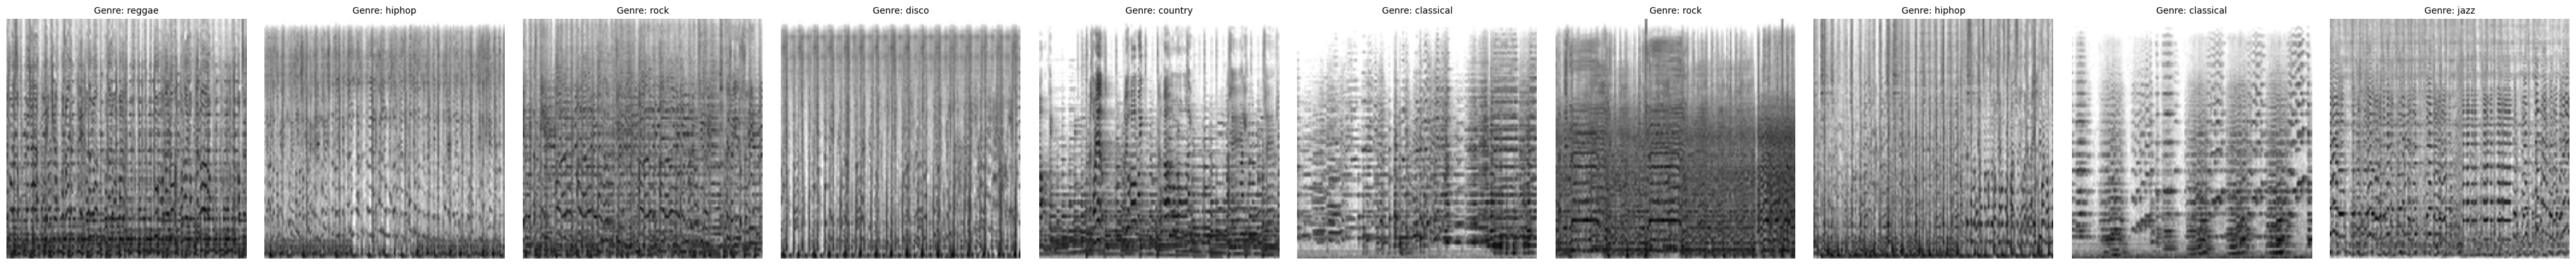

In [9]:
import matplotlib.pyplot as plt
import numpy as np
def show_images(loader, mean=0, std=1, num_images=12, figsize=(12, 9), denormalize=True):
    """
    Display a grid of images from a dataloader.
    
    Args:
        loader (DataLoader): DataLoader to get images from
        mean (float): Mean used for normalization, needed for denormalization
        std (float): Standard deviation used for normalization, needed for denormalization
        num_images (int): Number of images to display
        figsize (tuple): Figure size for the plot
        denormalize (bool): Whether to denormalize images before displaying
    """
    # Get a batch of images
    images, labels = next(iter(loader))
    
    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    axes = axes.ravel()  # Flatten the grid to make indexing easier
    
    # Calculate how many images to actually display
    num_to_display = min(num_images, len(images), len(axes))
    
    # Get class names from the dataset
    class_names = loader.dataset.dataset.classes
    
    # Plot images
    for idx in range(num_to_display):
        # Get the image and label
        img = images[idx]
        label_idx = labels[idx].item()
        class_name = class_names[label_idx]
        
        # Convert tensor to numpy for visualization
        img_np = img.cpu().numpy()
        
        # Handle grayscale images
        if img_np.shape[0] == 1:
            img_np = img_np.squeeze(0)  # Remove the channel dimension
            
            # Denormalize if requested
            if denormalize:
                img_np = img_np * std + mean
                
            axes[idx].imshow(img_np, cmap='gray')
        else:
            # Handle RGB images
            if denormalize:
                img_np = img_np * std + mean
                
            img_np = np.transpose(img_np, (1, 2, 0))  # Change from [C,H,W] to [H,W,C]
            axes[idx].imshow(img_np)
        
        # Add title and turn off axis
        axes[idx].set_title(f'Genre: {class_name}', fontsize=10)
        axes[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(num_to_display, len(axes)):
        axes[idx].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    return class_names

# Show sample images from the training set
num_images = 10
class_names = show_images(
    train_loader, 
    mean=mean,
    std=std,
    num_images=num_images, 
    figsize=(4*num_images, 4),
    denormalize=True
)

# Net1


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(180 * 180, 512)      # Hidden layer 1
        self.fc2 = nn.Linear(512, 128)            # Hidden layer 2
        self.out = nn.Linear(128, 10)             # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten input
        x = self.relu(self.fc1(x))   # Hidden layer 1 + activation
        x = self.relu(self.fc2(x))   # Hidden layer 2 + activation
        return self.out(x)           # Output logits

In [11]:
model = Net1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 🔥 Lower LR!
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=50)

# I want to save the model after training
torch.save(model.state_dict(), 'Net1-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")


📅 Epoch 1/50 | Loss: 76.6408 | Val Acc: 27.64%
📅 Epoch 2/50 | Loss: 37.1372 | Val Acc: 34.17%
📅 Epoch 3/50 | Loss: 26.7070 | Val Acc: 39.20%
📅 Epoch 4/50 | Loss: 18.0847 | Val Acc: 37.19%
📅 Epoch 5/50 | Loss: 13.4971 | Val Acc: 37.19%
📅 Epoch 6/50 | Loss: 8.4720 | Val Acc: 38.19%
📅 Epoch 7/50 | Loss: 3.2754 | Val Acc: 42.21%
📅 Epoch 8/50 | Loss: 1.8880 | Val Acc: 42.71%
📅 Epoch 9/50 | Loss: 1.0286 | Val Acc: 43.22%
📅 Epoch 10/50 | Loss: 0.8614 | Val Acc: 48.74%
📅 Epoch 11/50 | Loss: 1.2905 | Val Acc: 41.71%
📅 Epoch 12/50 | Loss: 1.3861 | Val Acc: 44.72%
📅 Epoch 13/50 | Loss: 3.2175 | Val Acc: 40.70%
📅 Epoch 14/50 | Loss: 2.8795 | Val Acc: 40.70%
📅 Epoch 15/50 | Loss: 0.9222 | Val Acc: 39.70%
📅 Epoch 16/50 | Loss: 0.8205 | Val Acc: 44.72%
📅 Epoch 17/50 | Loss: 1.6442 | Val Acc: 45.23%
📅 Epoch 18/50 | Loss: 0.6437 | Val Acc: 49.75%
📅 Epoch 19/50 | Loss: 1.6277 | Val Acc: 42.71%
📅 Epoch 20/50 | Loss: 0.7113 | Val Acc: 40.70%
📅 Epoch 21/50 | Loss: 0.5620 | Val Acc: 42.71%
📅 Epoch 22/50 | L

In [12]:

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100)

# I want to save the model after training
torch.save(model.state_dict(), 'Net1-100epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")


📅 Epoch 1/100 | Loss: 0.5364 | Val Acc: 42.21%
📅 Epoch 2/100 | Loss: 0.1447 | Val Acc: 43.22%
📅 Epoch 3/100 | Loss: 0.1913 | Val Acc: 41.71%
📅 Epoch 4/100 | Loss: 0.3519 | Val Acc: 44.22%
📅 Epoch 5/100 | Loss: 0.1505 | Val Acc: 42.21%
📅 Epoch 6/100 | Loss: 0.1746 | Val Acc: 43.22%
📅 Epoch 7/100 | Loss: 0.1308 | Val Acc: 41.21%
📅 Epoch 8/100 | Loss: 0.0771 | Val Acc: 42.71%
📅 Epoch 9/100 | Loss: 0.0912 | Val Acc: 41.71%
📅 Epoch 10/100 | Loss: 0.2217 | Val Acc: 44.72%
📅 Epoch 11/100 | Loss: 0.0951 | Val Acc: 41.21%
📅 Epoch 12/100 | Loss: 0.2186 | Val Acc: 42.71%
📅 Epoch 13/100 | Loss: 0.0598 | Val Acc: 39.70%
📅 Epoch 14/100 | Loss: 0.2812 | Val Acc: 44.22%
📅 Epoch 15/100 | Loss: 0.1711 | Val Acc: 45.23%
📅 Epoch 16/100 | Loss: 0.1113 | Val Acc: 43.22%
📅 Epoch 17/100 | Loss: 0.1372 | Val Acc: 43.22%
📅 Epoch 18/100 | Loss: 0.1905 | Val Acc: 38.69%
📅 Epoch 19/100 | Loss: 0.3072 | Val Acc: 43.22%
📅 Epoch 20/100 | Loss: 0.1114 | Val Acc: 43.22%
📅 Epoch 21/100 | Loss: 0.1397 | Val Acc: 42.71%
📅

# Net2


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # [B,16,180,180]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # [B,32,180,180]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                # [B,32,90,90]
        
        # Conv block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # [B,64,90,90]
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)# [B,128,90,90]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                # [B,128,45,45]

        # Fully connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 45 * 45, 256)  # Matches "out_features=256" in diagram
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
model = Net2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=50)

# I want to save the model after training
torch.save(model.state_dict(), 'Net2-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")

📅 Epoch 1/50 | Loss: 47.7847 | Val Acc: 30.15%
📅 Epoch 2/50 | Loss: 37.4774 | Val Acc: 35.18%
📅 Epoch 3/50 | Loss: 31.7525 | Val Acc: 41.71%
📅 Epoch 4/50 | Loss: 25.9761 | Val Acc: 41.21%
📅 Epoch 5/50 | Loss: 22.4427 | Val Acc: 50.25%
📅 Epoch 6/50 | Loss: 18.2564 | Val Acc: 55.28%
📅 Epoch 7/50 | Loss: 15.6737 | Val Acc: 59.30%
📅 Epoch 8/50 | Loss: 10.7494 | Val Acc: 53.77%
📅 Epoch 9/50 | Loss: 8.2393 | Val Acc: 61.31%
📅 Epoch 10/50 | Loss: 6.7555 | Val Acc: 57.79%
📅 Epoch 11/50 | Loss: 5.1619 | Val Acc: 55.78%
📅 Epoch 12/50 | Loss: 3.7453 | Val Acc: 56.28%
📅 Epoch 13/50 | Loss: 3.1026 | Val Acc: 60.80%
📅 Epoch 14/50 | Loss: 1.9000 | Val Acc: 57.79%
📅 Epoch 15/50 | Loss: 1.3646 | Val Acc: 59.80%
📅 Epoch 16/50 | Loss: 1.0750 | Val Acc: 60.80%
📅 Epoch 17/50 | Loss: 1.0601 | Val Acc: 60.80%
📅 Epoch 18/50 | Loss: 0.9001 | Val Acc: 57.79%
📅 Epoch 19/50 | Loss: 0.6556 | Val Acc: 57.29%
📅 Epoch 20/50 | Loss: 0.3761 | Val Acc: 60.80%
📅 Epoch 21/50 | Loss: 0.5096 | Val Acc: 61.31%
📅 Epoch 22/50 

In [15]:
model = Net2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100)

# I want to save the model after training
torch.save(model.state_dict(), 'Net2-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")


📅 Epoch 1/100 | Loss: 60.4098 | Val Acc: 25.13%
📅 Epoch 2/100 | Loss: 40.1135 | Val Acc: 35.18%


KeyboardInterrupt: 

# Net3


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 45 * 45, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
model = Net3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=50)

# I want to save the model after training
torch.save(model.state_dict(), 'Net3-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")

📅 Epoch 1/50 | Loss: 216.6057 | Val Acc: 18.59%
📅 Epoch 2/50 | Loss: 43.3008 | Val Acc: 36.18%
📅 Epoch 3/50 | Loss: 26.2192 | Val Acc: 42.21%
📅 Epoch 4/50 | Loss: 21.1745 | Val Acc: 54.27%
📅 Epoch 5/50 | Loss: 15.1139 | Val Acc: 60.30%
📅 Epoch 6/50 | Loss: 12.8520 | Val Acc: 57.29%
📅 Epoch 7/50 | Loss: 7.4624 | Val Acc: 59.30%
📅 Epoch 8/50 | Loss: 5.5462 | Val Acc: 66.83%
📅 Epoch 9/50 | Loss: 4.3632 | Val Acc: 62.81%
📅 Epoch 10/50 | Loss: 2.6753 | Val Acc: 69.85%
📅 Epoch 11/50 | Loss: 1.5938 | Val Acc: 67.34%
📅 Epoch 12/50 | Loss: 0.9114 | Val Acc: 67.34%
📅 Epoch 13/50 | Loss: 0.7681 | Val Acc: 65.83%
📅 Epoch 14/50 | Loss: 0.6593 | Val Acc: 70.85%
📅 Epoch 15/50 | Loss: 0.5464 | Val Acc: 72.86%
📅 Epoch 16/50 | Loss: 0.5018 | Val Acc: 71.36%
📅 Epoch 17/50 | Loss: 0.4153 | Val Acc: 70.35%
📅 Epoch 18/50 | Loss: 0.3994 | Val Acc: 69.35%
📅 Epoch 19/50 | Loss: 0.5180 | Val Acc: 69.85%
📅 Epoch 20/50 | Loss: 0.4169 | Val Acc: 72.86%
📅 Epoch 21/50 | Loss: 0.3125 | Val Acc: 70.85%
📅 Epoch 22/50 |

In [ ]:
model = Net3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100)

# I want to save the model after training
torch.save(model.state_dict(), 'Net3-100epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")

# Net4


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 45 * 45, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
model = Net4().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=50)

# I want to save the model after training
torch.save(model.state_dict(), 'Net4-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")

📅 Epoch 1/50 | Loss: 1004.0506 | Val Acc: 24.62%
📅 Epoch 2/50 | Loss: 147.9282 | Val Acc: 36.68%
📅 Epoch 3/50 | Loss: 89.2710 | Val Acc: 35.68%
📅 Epoch 4/50 | Loss: 66.1360 | Val Acc: 38.19%
📅 Epoch 5/50 | Loss: 47.7623 | Val Acc: 43.72%
📅 Epoch 6/50 | Loss: 38.9071 | Val Acc: 46.73%
📅 Epoch 7/50 | Loss: 33.6563 | Val Acc: 49.25%
📅 Epoch 8/50 | Loss: 30.3693 | Val Acc: 34.67%
📅 Epoch 9/50 | Loss: 35.0060 | Val Acc: 26.63%
📅 Epoch 10/50 | Loss: 27.8594 | Val Acc: 56.78%
📅 Epoch 11/50 | Loss: 14.2252 | Val Acc: 40.70%
📅 Epoch 12/50 | Loss: 25.6914 | Val Acc: 54.27%
📅 Epoch 13/50 | Loss: 4.0146 | Val Acc: 61.81%
📅 Epoch 14/50 | Loss: 22.9945 | Val Acc: 49.75%
📅 Epoch 15/50 | Loss: 2.3267 | Val Acc: 53.77%
📅 Epoch 16/50 | Loss: 2.7789 | Val Acc: 63.32%
📅 Epoch 17/50 | Loss: 2.7890 | Val Acc: 54.27%
📅 Epoch 18/50 | Loss: 71.6825 | Val Acc: 39.20%
📅 Epoch 19/50 | Loss: 8.4904 | Val Acc: 45.73%
📅 Epoch 20/50 | Loss: 1.5011 | Val Acc: 63.82%
📅 Epoch 21/50 | Loss: 0.9929 | Val Acc: 64.82%
📅 Epo

In [ ]:
model = Net4().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100)

# I want to save the model after training
torch.save(model.state_dict(), 'Net4-50epoch.pth')

print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")

# Net5


In [28]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class MFCCDataset(Dataset):
    def __init__(self, root_dir, n_mfcc=40, max_len=400, include_delta=True, 
                 include_energy=True, n_fft=2048, hop_length=512, sample_rate=None, 
                 transform=None, scaler=None, train_mode=True):
        """
        Enhanced MFCC Dataset with additional features
        
        Args:
            root_dir (str): Directory with audio files organized by genre
            n_mfcc (int): Number of MFCC coefficients
            max_len (int): Maximum sequence length (samples shorter will be padded)
            include_delta (bool): Whether to include delta and delta-delta features
            include_energy (bool): Whether to include energy as first MFCC
            n_fft (int): FFT window size
            hop_length (int): Hop length for feature extraction
            sample_rate (int, optional): Target sample rate, None keeps original
            transform (callable, optional): Optional transform to be applied
            scaler (object, optional): Pre-fit scaler to apply normalization
            train_mode (bool): Whether to fit a new scaler on this dataset
        """
        self.root_dir = root_dir
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        self.include_delta = include_delta
        self.include_energy = include_energy
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.sample_rate = sample_rate
        self.transform = transform
        self.scaler = scaler
        self.train_mode = train_mode
        
        # Stats for tracking
        self.total_length = 0
        self.min_length = float('inf')
        self.max_length = 0
        
        # Load data with progress bar
        self._load_data()
    
    def _extract_features(self, y, sr):
        """Extract MFCCs with additional delta features if requested"""
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=y, sr=sr, 
            n_mfcc=self.n_mfcc, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            htk=True,  # Use HTK formula for better compatibility with standards
        )
        
        # Add delta and delta-delta features if requested
        if self.include_delta:
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)
        else:
            features = mfccs
        
        # Add energy feature if requested
        if self.include_energy:
            # Calculate energy (can be done with various methods)
            energy = librosa.feature.rms(y=y, frame_length=self.n_fft, hop_length=self.hop_length)
            features = np.concatenate([energy, features], axis=0)
        
        features = features.T  # Convert to time-major format [time, features]
        
        # Update stats
        length = features.shape[0]
        self.total_length += length
        self.min_length = min(self.min_length, length)
        self.max_length = max(self.max_length, length)
        
        # Handle sequence length: pad or truncate
        if length > self.max_len:
            features = features[:self.max_len, :]
        elif length < self.max_len:
            # Pad with zeros
            padding = np.zeros((self.max_len - length, features.shape[1]))
            features = np.concatenate([features, padding], axis=0)
            
        return features
    
    def _load_data(self):
        """Load audio files and extract features"""
        self.data = []
        self.labels = []
        self.filenames = []  # Keep track of filenames for debugging
        
        # Collect genre names based on folders
        self.genres = []
        for item in os.listdir(self.root_dir):
            if os.path.isdir(os.path.join(self.root_dir, item)):
                self.genres.append(item)
        self.genres.sort()  # Ensure consistent genre ordering
        
        genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        all_features = []
        
        print(f"Loading audio from {self.root_dir}")
        print(f"Found {len(self.genres)} genres: {', '.join(self.genres)}")
        
        for genre_name in self.genres:
            genre_dir = os.path.join(self.root_dir, genre_name)
            label_idx = genre_to_idx[genre_name]
            
            file_list = [f for f in os.listdir(genre_dir) 
                        if f.endswith('.wav') or f.endswith('.mp3')]
            
            print(f"Processing {len(file_list)} files for genre '{genre_name}'")
            
            for filename in tqdm(file_list, desc=f"Genre: {genre_name}"):
                try:
                    file_path = os.path.join(genre_dir, filename)
                    
                    # Load and extract features
                    y, sr = librosa.load(file_path, sr=self.sample_rate)
                    
                    # Apply a simple audio quality check
                    if np.isnan(y).any() or np.max(np.abs(y)) < 1e-6:
                        print(f"Warning: {file_path} has audio quality issues. Skipping.")
                        continue
                    
                    # Extract MFCCs and additional features
                    features = self._extract_features(y, sr)
                    
                    all_features.append(features)
                    self.filenames.append(filename)
                    self.labels.append(label_idx)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
        
        # Convert to numpy arrays for processing
        all_features = np.array(all_features)
        
        # Fit scaler if in training mode and no scaler provided
        feature_dim = all_features.shape[2]
        if self.train_mode and self.scaler is None:
            # Reshape for fitting the scaler
            flat_features = all_features.reshape(-1, feature_dim)
            self.scaler = StandardScaler().fit(flat_features)
            print(f"Fitted scaler with mean: {self.scaler.mean_.mean():.4f}, std: {self.scaler.scale_.mean():.4f}")
        
        # Apply scaling if scaler is available
        if self.scaler is not None:
            # Reshape, transform, and reshape back
            orig_shape = all_features.shape
            flat_features = all_features.reshape(-1, feature_dim)
            scaled_features = self.scaler.transform(flat_features)
            all_features = scaled_features.reshape(orig_shape)
        
        # Convert to torch tensors
        self.data = [torch.tensor(features, dtype=torch.float32) for features in all_features]
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        
        print(f"Dataset loading complete. {len(self.data)} samples, {feature_dim} features.")
        print(f"Sequence length stats - Min: {self.min_length}, Max: {self.max_length}, Used: {self.max_len}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            features = self.transform(features)
            
        return features, label

def get_mfcc_dataloaders(data_path, batch_size=32, n_mfcc=40, max_len=400, 
                                include_delta=True, include_energy=True, 
                                n_fft=2048, hop_length=512):
    """Create train, validation, and test data loaders with consistent preprocessing"""
    
    # Create the training dataset
    train_dataset = MFCCDataset(
        root_dir=data_path,
        n_mfcc=n_mfcc,
        max_len=max_len,
        include_delta=include_delta,
        include_energy=include_energy,
        n_fft=n_fft,
        hop_length=hop_length,
        train_mode=True  # This will fit a scaler
    )
    
    # Get the genres
    genres = train_dataset.genres
    scaler = train_dataset.scaler
    
    # Calculate total length for dataset splits
    total_len = len(train_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    test_len = total_len - train_len - val_len
    
    # Split the dataset
    train_set, val_set, test_set = random_split(
        train_dataset, 
        [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42)  # Fixed seed for reproducibility
    )
    
    # Create class-balanced samplers for small datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, genres, scaler

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class AttentionLayer(nn.Module):
    """Attention mechanism to focus on important timesteps in sequence"""
    def __init__(self, hidden_size, attention_size=128):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, attention_size),
            nn.Tanh(),
            nn.Linear(attention_size, 1)
        )
    
    def forward(self, hidden_states):
        # hidden_states: [batch, seq_len, hidden_size]
        # Calculate attention weights
        attention_weights = self.attention(hidden_states)  # [batch, seq_len, 1]
        attention_weights = F.softmax(attention_weights, dim=1)  # [batch, seq_len, 1]
        
        # Apply attention weights to get context vector
        context = torch.sum(hidden_states * attention_weights, dim=1)  # [batch, hidden_size]
        return context, attention_weights

class Net5(nn.Module):
    def __init__(self, input_size=40, hidden_size=256, num_layers=2, num_classes=10, 
                 dropout=0.3, bidirectional=True, use_attention=True):
        super(Net5, self).__init__()
        
        # Whether to use bidirectional LSTM
        self.bidirectional = bidirectional
        # Whether to use attention mechanism
        self.use_attention = use_attention
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Calculate the output size from LSTM
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Attention layer if requested
        if use_attention:
            self.attention = AttentionLayer(lstm_output_size)
        
        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(lstm_output_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout)
        
        # Final classification layer
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # x: [batch, seq_len, features]
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch, seq_len, hidden_size(*2 if bidirectional)]
        
        # Apply attention if requested, otherwise use the last hidden state
        if self.use_attention:
            context, attention_weights = self.attention(lstm_out)
        else:
            if self.bidirectional:
                # When bidirectional, concatenate the last hidden state from both directions
                context = torch.cat([lstm_out[:, -1, :lstm_out.size(2)//2], 
                                    lstm_out[:, 0, lstm_out.size(2)//2:]], dim=1)
            else:
                # Use the last hidden state when not bidirectional
                context = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        x = F.relu(self.bn1(self.fc1(context)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Final output
        output = self.fc3(x)
        return output

# Helper function to count parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model, train_loader, val_loader, optimizer, scheduler=None, 
                        loss_fn=nn.CrossEntropyLoss(), device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                        epochs=50, patience=10, checkpoint_path='best_model.pt'):
    """
    Training function with early stopping and learning rate scheduling
    """
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=checkpoint_path)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate training statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                
                # Calculate validation statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        # Print epoch results
        print(f'Epoch: {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_loss)  # For ReduceLROnPlateau
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
    
    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))
    
    return model, history

def evaluate_model(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Evaluate model performance on test set
    
    Returns:
        accuracy (float): Classification accuracy
        confusion (numpy.ndarray): Confusion matrix
        class_accuracies (list): Per-class accuracies
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate overall accuracy
    accuracy = 100. * correct / total
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(all_targets, all_preds)
    
    # Calculate per-class accuracy
    per_class_accuracy = []
    for i in range(len(conf_mat)):
        if sum(conf_mat[i, :]) > 0:  # Avoid division by zero
            per_class_accuracy.append(conf_mat[i, i] / sum(conf_mat[i, :]) * 100)
        else:
            per_class_accuracy.append(0)
    
    return accuracy, conf_mat, per_class_accuracy

Using device: cpu
Loading and preprocessing audio data...
Loading audio from ./Data/genres_original
Found 10 genres: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
Processing 100 files for genre 'blues'


Genre: blues: 100%|██████████| 100/100 [00:01<00:00, 63.34it/s]


Processing 100 files for genre 'classical'


Genre: classical: 100%|██████████| 100/100 [00:01<00:00, 64.26it/s]


Processing 100 files for genre 'country'


Genre: country: 100%|██████████| 100/100 [00:01<00:00, 65.32it/s]


Processing 100 files for genre 'disco'


Genre: disco: 100%|██████████| 100/100 [00:01<00:00, 65.85it/s]


Processing 100 files for genre 'hiphop'


Genre: hiphop: 100%|██████████| 100/100 [00:01<00:00, 66.45it/s]


Processing 100 files for genre 'jazz'


Genre: jazz:  42%|████▏     | 42/100 [00:00<00:00, 62.72it/s]/var/folders/60/w45408950l338hfzlxx878vc0000gn/T/ipykernel_39451/4132246454.py:125: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=self.sample_rate)
/Users/camelot/MSc/music-genre-classification/music-classification/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Genre: jazz:  57%|█████▋    | 57/100 [00:00<00:00, 65.95it/s]

Error processing jazz.00054.wav: 


Genre: jazz: 100%|██████████| 100/100 [00:01<00:00, 65.32it/s]


Processing 100 files for genre 'metal'


Genre: metal: 100%|██████████| 100/100 [00:01<00:00, 67.75it/s]


Processing 100 files for genre 'pop'


Genre: pop: 100%|██████████| 100/100 [00:01<00:00, 67.44it/s]


Processing 100 files for genre 'reggae'


Genre: reggae: 100%|██████████| 100/100 [00:01<00:00, 66.41it/s]


Processing 100 files for genre 'rock'


Genre: rock: 100%|██████████| 100/100 [00:01<00:00, 64.29it/s]
/Users/camelot/MSc/music-genre-classification/music-classification/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fitted scaler with mean: -1.1455, std: 7.7666
Dataset loading complete. 999 samples, 61 features.
Sequence length stats - Min: 1290, Max: 1320, Used: 300
Input feature size: 61
Model parameters: 724,619
Training model...
Epoch: 1/80 | Train Loss: 2.0291 | Train Acc: 27.18% | Val Loss: 2.1610 | Val Acc: 18.09%
Validation loss decreased (inf --> 2.160955).  Saving model ...
Epoch: 2/80 | Train Loss: 1.6296 | Train Acc: 42.78% | Val Loss: 1.7874 | Val Acc: 52.26%
Validation loss decreased (2.160955 --> 1.787404).  Saving model ...
Epoch: 3/80 | Train Loss: 1.4043 | Train Acc: 53.36% | Val Loss: 1.3638 | Val Acc: 63.82%
Validation loss decreased (1.787404 --> 1.363823).  Saving model ...
Epoch: 4/80 | Train Loss: 1.1754 | Train Acc: 62.09% | Val Loss: 1.1862 | Val Acc: 63.32%
Validation loss decreased (1.363823 --> 1.186181).  Saving model ...
Epoch: 5/80 | Train Loss: 0.9861 | Train Acc: 70.53% | Val Loss: 0.9785 | Val Acc: 75.88%
Validation loss decreased (1.186181 --> 0.978529).  Saving

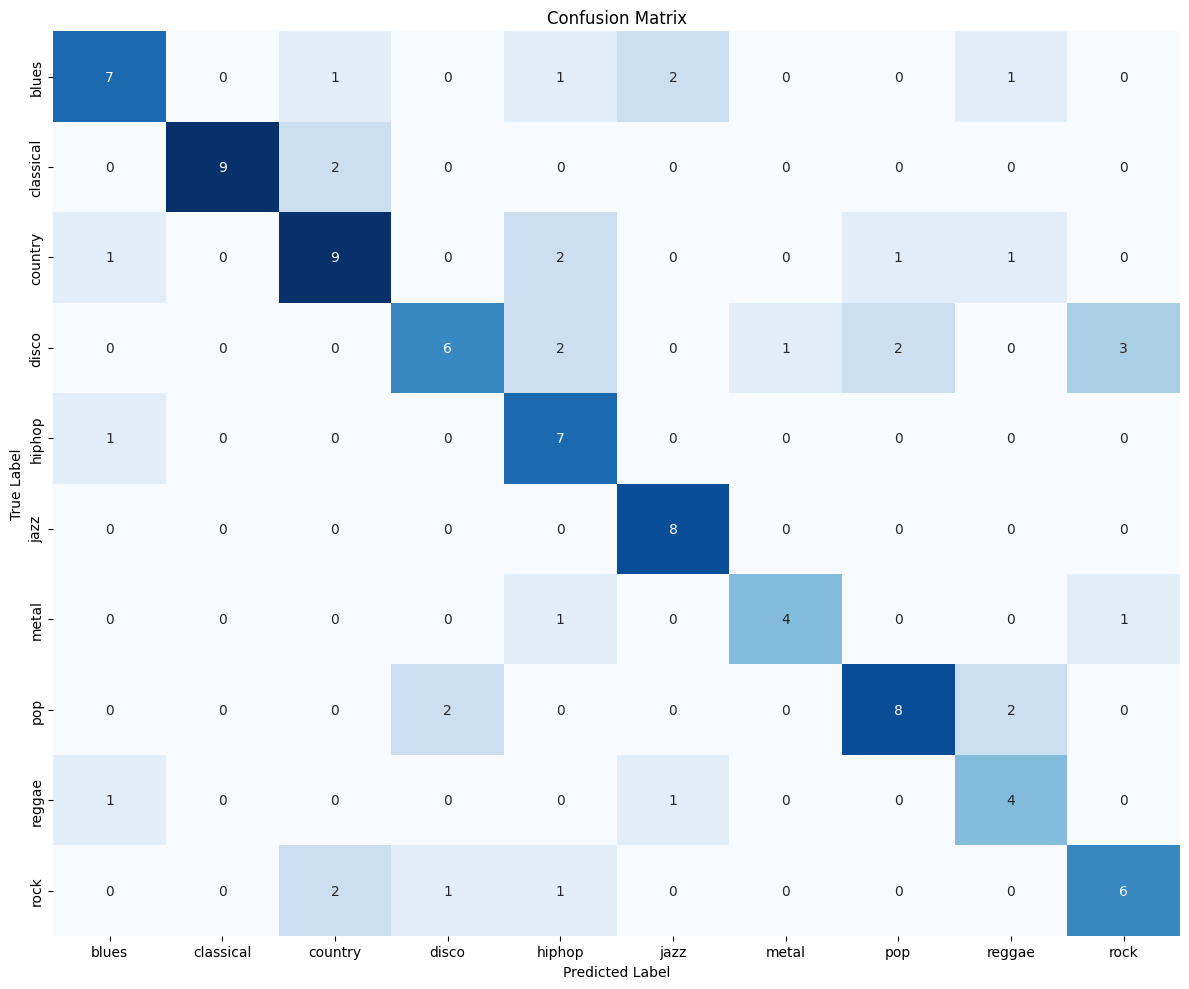

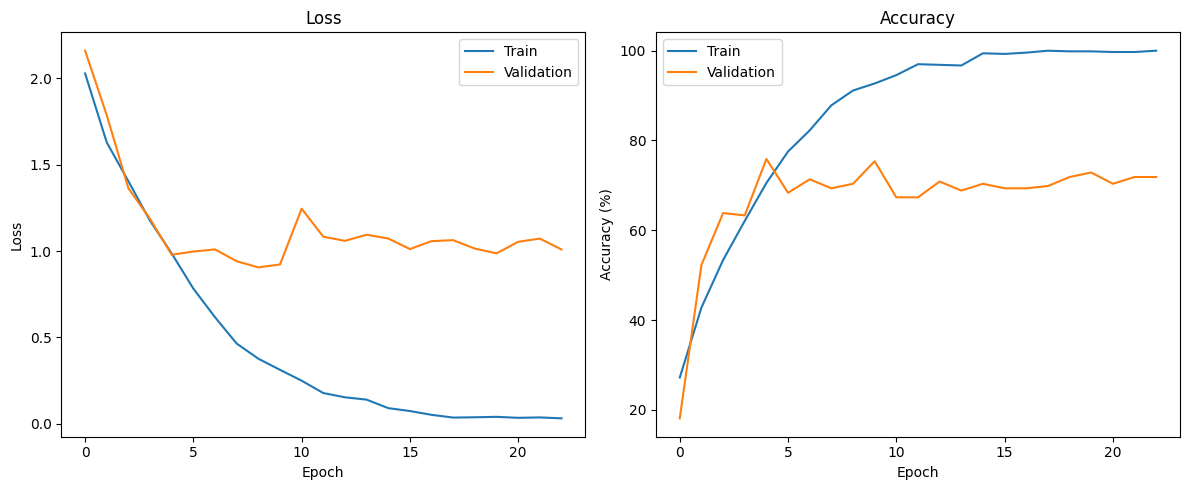

Model and training results saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Define hyperparameters
n_mfcc = 20             # Number of MFCC coefficients
max_len = 300           # Max sequence length
include_delta = True    # Include delta and delta-delta features
include_energy = True   # Include energy as the first MFCC
n_fft = 2048            # FFT window size
hop_length = 512        # Hop length
batch_size = 32         # Batch size
hidden_size = 128       # LSTM hidden size
num_layers = 2          # Number of LSTM layers
dropout = 0.4           # Dropout rate
learning_rate = 0.001   # Learning rate
epochs = 80             # Max epochs
patience = 15           # Early stopping patience
bidirectional = True    # Use bidirectional LSTM
use_attention = True    # Use attention mechanism

# Load dataset
data_path = "./Data/genres_original"  # Path to your audio files

print("Loading and preprocessing audio data...")
train_loader, val_loader, test_loader, genres, scaler = get_mfcc_dataloaders(
    data_path=data_path,
    batch_size=batch_size,
    n_mfcc=n_mfcc,
    max_len=max_len,
    include_delta=include_delta,
    include_energy=include_energy,
    n_fft=n_fft,
    hop_length=hop_length
)

# Calculate input size based on features
sample_batch, _ = next(iter(train_loader))
input_size = sample_batch.size(-1)
print(f"Input feature size: {input_size}")

# Initialize model
model = Net5(
    input_size=input_size, 
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=len(genres),
    dropout=dropout,
    bidirectional=bidirectional,
    use_attention=use_attention
).to(device)

print(f"Model parameters: {count_parameters(model):,}")

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
criterion = nn.CrossEntropyLoss()

# Train the model
print("Training model...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=criterion,
    device=device,
    epochs=epochs,
    patience=patience,
    checkpoint_path="best_net5_model.pt"
)

# Evaluate on test set
print("Evaluating model on test set...")
test_accuracy, confusion_mat, per_class_acc = evaluate_model(model, test_loader, device)
print(f"highest val_acc: {max(history['val_acc']):.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Per-class accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"  {genres[i]}: {acc:.2f}%")

# Create confusion matrix visualization
plt.figure(figsize=(12, 10))
conf_df = pd.DataFrame(confusion_mat, index=genres, columns=genres)
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("net5_confusion_matrix.png")
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig("net5_training_history.png")
plt.show()

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'genres': genres,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'bidirectional': bidirectional,
    'use_attention': use_attention,
    'test_accuracy': test_accuracy,
    'confusion_matrix': confusion_mat.tolist(),
    'per_class_accuracy': per_class_acc,
}, 'net5_full_model.pth')

print("Model and training results saved successfully!")

# Net6


In [52]:
class LSTMConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=10, seq_len=400, output_dim=40, embed_dim=100, hidden_dim=256):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        self.label_embed = nn.Embedding(label_dim, embed_dim)

        self.fc = nn.Sequential(
            nn.Linear(noise_dim + embed_dim, hidden_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)

        self.to_mfcc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_embed(labels)  # [B, embed_dim]
        x = torch.cat([z, label_embed], dim=1)  # [B, noise + embed]
        x = self.fc(x)  # [B, hidden]
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # [B, seq_len, hidden]
        lstm_out, _ = self.lstm(x)  # [B, seq_len, hidden]
        mfcc = self.to_mfcc(lstm_out)  # [B, seq_len, output_dim]
        return mfcc


In [53]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=40, seq_len=400, label_dim=10, embed_dim=100):
        super().__init__()
        self.label_embed = nn.Embedding(label_dim, embed_dim)

        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(seq_len * input_dim + embed_dim, 1024)),
            nn.LayerNorm(1024),  # ✅ helps stabilize gradients
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(1024, 1))
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), -1)  # [B, 400*40]
        label_embedding = self.label_embed(labels)  # [B, embed_dim]
        x = torch.cat([x, label_embedding], dim=1)  # [B, 400*40 + embed_dim]
        return self.fc(x)


In [54]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [55]:
# Gradient penalty
def gradient_penalty(critic, real_data, fake_data, labels):
    alpha = torch.rand(real_data.size(0), 1, 1).to(real_data.device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)

    critic_scores = critic(interpolates, labels)  # ✅ Pass labels here
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- Setup ---
noise_dim = 100
seq_len = 400
n_mfcc = 40
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate Generator and Discriminator
generator = LSTMConditionalGenerator(noise_dim=noise_dim, output_dim=n_mfcc, seq_len=seq_len).to(device)
discriminator = ConditionalDiscriminator(input_dim=n_mfcc, seq_len=seq_len).to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


lambda_gp = 10

def train_gan(train_loader, epochs=50):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        d_loss_epoch = 0.0
        g_loss_epoch = 0.0

        for real_mfccs, real_labels in tqdm(train_loader):
            real_mfccs = real_mfccs.to(device)
            real_mfccs += 0.01 * torch.randn_like(real_mfccs)  # Add noise to real data
            real_labels = real_labels.to(device)
            b_size = real_mfccs.size(0)

            # === Train Discriminator ===
            for _ in range(1):
                z = torch.randn(b_size, noise_dim).to(device)
                fake_labels = torch.randint(0, 10, (b_size,), device=device)
                fake_mfccs = generator(z, fake_labels)

                d_optimizer.zero_grad()
                real_scores = discriminator(real_mfccs, real_labels)
                fake_scores = discriminator(fake_mfccs.detach(), fake_labels)
                gp = gradient_penalty(discriminator, real_mfccs, fake_mfccs, fake_labels)

                d_loss = -torch.mean(real_scores) + torch.mean(fake_scores) + lambda_gp * gp
                d_loss.backward()
                d_optimizer.step()

            # === Train Generator ===
            z = torch.randn(b_size, noise_dim).to(device)
            fake_labels = torch.randint(0, 10, (b_size,), device=device)
            fake_mfccs = generator(z, fake_labels)

            g_optimizer.zero_grad()
            fake_scores = discriminator(fake_mfccs, fake_labels)
            g_loss = -torch.mean(fake_scores)
            g_loss.backward()
            g_optimizer.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss_epoch:.4f} | G Loss: {g_loss_epoch:.4f}")

    torch.save(generator.state_dict(), "generator_mfcc.pth")
    print("✅ Finished training GAN and saved generator.")


In [57]:
def generate_labeled_synthetic_data(generator, num_samples_per_class, num_classes=10):
    generator.eval()
    all_mfccs = []
    all_labels = []

    with torch.no_grad():
        for label in range(num_classes):
            labels = torch.full((num_samples_per_class,), label, dtype=torch.long).to(device)
            z = torch.randn(num_samples_per_class, noise_dim).to(device)
            mfccs = generator(z, labels).cpu()
            all_mfccs.append(mfccs)
            all_labels.append(labels.cpu())

    return torch.cat(all_mfccs, dim=0), torch.cat(all_labels, dim=0)


In [58]:
train_dataset = MFCCDataset(root_dir="./Data/genres_original", n_mfcc=40, max_len=400)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_gan(train_loader, epochs=50)  # Train the GAN for 50 epochs

100%|██████████| 32/32 [00:02<00:00, 11.03it/s]


Epoch [1/50] | D Loss: -9.5531 | G Loss: 227.5822


100%|██████████| 32/32 [00:02<00:00, 12.53it/s]


Epoch [2/50] | D Loss: -149.6817 | G Loss: 274.8071


100%|██████████| 32/32 [00:02<00:00, 12.79it/s]


Epoch [3/50] | D Loss: -233.9974 | G Loss: 239.9270


100%|██████████| 32/32 [00:02<00:00, 12.89it/s]


Epoch [4/50] | D Loss: -295.3924 | G Loss: 191.5115


100%|██████████| 32/32 [00:02<00:00, 12.56it/s]


Epoch [5/50] | D Loss: -352.5371 | G Loss: 183.7509


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


Epoch [6/50] | D Loss: -324.0363 | G Loss: 93.8655


100%|██████████| 32/32 [00:02<00:00, 12.38it/s]


Epoch [7/50] | D Loss: -267.6178 | G Loss: 50.1470


100%|██████████| 32/32 [00:02<00:00, 12.28it/s]


Epoch [8/50] | D Loss: -132.6761 | G Loss: -118.3103


100%|██████████| 32/32 [00:02<00:00, 12.73it/s]


Epoch [9/50] | D Loss: -4.9617 | G Loss: -294.5081


100%|██████████| 32/32 [00:02<00:00, 12.83it/s]


Epoch [10/50] | D Loss: 36.6967 | G Loss: -360.6305


100%|██████████| 32/32 [00:02<00:00, 12.85it/s]


Epoch [11/50] | D Loss: -3.3770 | G Loss: -306.5780


100%|██████████| 32/32 [00:02<00:00, 13.16it/s]


Epoch [12/50] | D Loss: -62.6188 | G Loss: -194.5518


100%|██████████| 32/32 [00:02<00:00, 12.77it/s]


Epoch [13/50] | D Loss: -134.3724 | G Loss: -51.0397


100%|██████████| 32/32 [00:02<00:00, 12.94it/s]


Epoch [14/50] | D Loss: -205.2057 | G Loss: 84.9589


100%|██████████| 32/32 [00:02<00:00, 12.99it/s]


Epoch [15/50] | D Loss: -295.8941 | G Loss: 211.1347


100%|██████████| 32/32 [00:02<00:00, 12.79it/s]


Epoch [16/50] | D Loss: -350.9888 | G Loss: 314.2811


100%|██████████| 32/32 [00:02<00:00, 12.87it/s]


Epoch [17/50] | D Loss: -378.1411 | G Loss: 379.7907


100%|██████████| 32/32 [00:02<00:00, 12.95it/s]


Epoch [18/50] | D Loss: -350.2141 | G Loss: 353.8005


100%|██████████| 32/32 [00:02<00:00, 12.62it/s]


Epoch [19/50] | D Loss: -365.6400 | G Loss: 280.4966


100%|██████████| 32/32 [00:02<00:00, 12.88it/s]


Epoch [20/50] | D Loss: -449.8089 | G Loss: 269.3264


100%|██████████| 32/32 [00:02<00:00, 12.72it/s]


Epoch [21/50] | D Loss: -498.4795 | G Loss: 256.4456


100%|██████████| 32/32 [00:02<00:00, 12.67it/s]


Epoch [22/50] | D Loss: -500.7932 | G Loss: 228.0607


100%|██████████| 32/32 [00:02<00:00, 12.98it/s]


Epoch [23/50] | D Loss: -520.9754 | G Loss: 218.3810


100%|██████████| 32/32 [00:02<00:00, 12.67it/s]


Epoch [24/50] | D Loss: -511.4878 | G Loss: 204.2411


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


Epoch [25/50] | D Loss: -505.1572 | G Loss: 191.3090


100%|██████████| 32/32 [00:02<00:00, 12.81it/s]


Epoch [26/50] | D Loss: -422.1862 | G Loss: 120.6504


100%|██████████| 32/32 [00:02<00:00, 12.86it/s]


Epoch [27/50] | D Loss: -353.3743 | G Loss: 91.5349


100%|██████████| 32/32 [00:02<00:00, 12.73it/s]


Epoch [28/50] | D Loss: -343.8088 | G Loss: 141.4837


100%|██████████| 32/32 [00:02<00:00, 12.76it/s]


Epoch [29/50] | D Loss: -386.8930 | G Loss: 221.2267


100%|██████████| 32/32 [00:02<00:00, 12.65it/s]


Epoch [30/50] | D Loss: -439.7766 | G Loss: 281.0159


100%|██████████| 32/32 [00:02<00:00, 12.74it/s]


Epoch [31/50] | D Loss: -471.6460 | G Loss: 292.9228


100%|██████████| 32/32 [00:02<00:00, 12.99it/s]


Epoch [32/50] | D Loss: -485.5030 | G Loss: 308.4058


100%|██████████| 32/32 [00:02<00:00, 13.06it/s]


Epoch [33/50] | D Loss: -501.7487 | G Loss: 291.1845


100%|██████████| 32/32 [00:02<00:00, 12.95it/s]


Epoch [34/50] | D Loss: -511.2484 | G Loss: 279.6824


100%|██████████| 32/32 [00:02<00:00, 12.80it/s]


Epoch [35/50] | D Loss: -528.4295 | G Loss: 269.2722


100%|██████████| 32/32 [00:02<00:00, 12.65it/s]


Epoch [36/50] | D Loss: -532.6933 | G Loss: 264.7604


100%|██████████| 32/32 [00:02<00:00, 12.91it/s]


Epoch [37/50] | D Loss: -533.5594 | G Loss: 258.6576


100%|██████████| 32/32 [00:02<00:00, 12.91it/s]


Epoch [38/50] | D Loss: -543.0846 | G Loss: 243.2908


100%|██████████| 32/32 [00:02<00:00, 12.68it/s]


Epoch [39/50] | D Loss: -536.2709 | G Loss: 239.8422


100%|██████████| 32/32 [00:02<00:00, 12.56it/s]


Epoch [40/50] | D Loss: -535.5838 | G Loss: 243.0634


100%|██████████| 32/32 [00:02<00:00, 12.45it/s]


Epoch [41/50] | D Loss: -526.0624 | G Loss: 244.7154


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


Epoch [42/50] | D Loss: -534.4104 | G Loss: 249.5369


100%|██████████| 32/32 [00:02<00:00, 12.48it/s]


Epoch [43/50] | D Loss: -542.0757 | G Loss: 259.3483


100%|██████████| 32/32 [00:02<00:00, 12.36it/s]


Epoch [44/50] | D Loss: -553.2532 | G Loss: 266.1341


100%|██████████| 32/32 [00:02<00:00, 12.26it/s]


Epoch [45/50] | D Loss: -560.1413 | G Loss: 273.4044


100%|██████████| 32/32 [00:02<00:00, 12.64it/s]


Epoch [46/50] | D Loss: -562.9444 | G Loss: 270.1137


100%|██████████| 32/32 [00:02<00:00, 12.44it/s]


Epoch [47/50] | D Loss: -576.3262 | G Loss: 278.1062


100%|██████████| 32/32 [00:02<00:00, 12.38it/s]


Epoch [48/50] | D Loss: -578.9027 | G Loss: 273.4781


100%|██████████| 32/32 [00:02<00:00, 12.78it/s]


Epoch [49/50] | D Loss: -587.6587 | G Loss: 272.7935


100%|██████████| 32/32 [00:02<00:00, 12.37it/s]

Epoch [50/50] | D Loss: -587.0341 | G Loss: 275.6706
✅ Finished training GAN and saved generator.


In [59]:
generator.load_state_dict(torch.load("generator_mfcc.pth"))
generator.eval()

LSTMConditionalGenerator(
  (label_embed): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): ReLU()
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (to_mfcc): Sequential(
    (0): Linear(in_features=256, out_features=40, bias=True)
    (1): Tanh()
  )
)

In [60]:
synthetic_mfccs, synthetic_labels = generate_labeled_synthetic_data(generator, num_samples_per_class=100)

# Combine with real data
real_mfccs = torch.stack([x[0] for x in train_dataset])
real_labels = torch.tensor([x[1] for x in train_dataset])
all_mfccs = torch.cat([real_mfccs, synthetic_mfccs], dim=0)
all_labels = torch.cat([real_labels, synthetic_labels], dim=0)

augmented_dataset = TensorDataset(all_mfccs, all_labels)


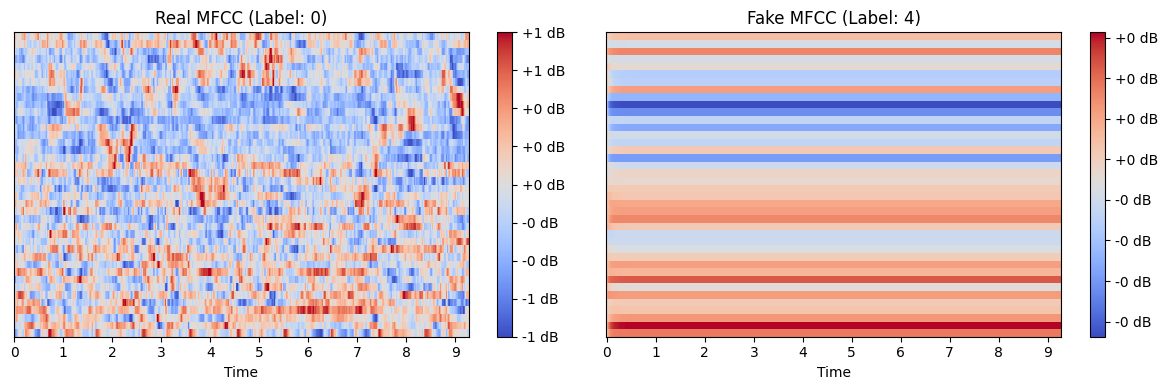

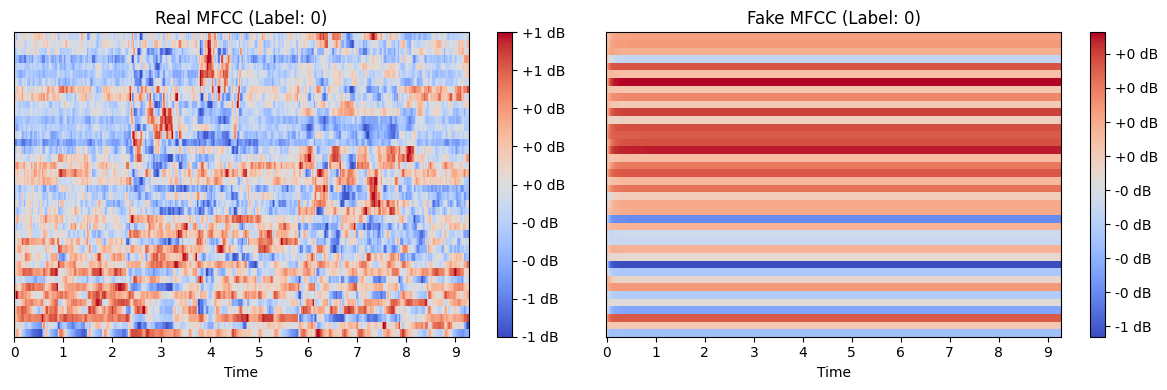

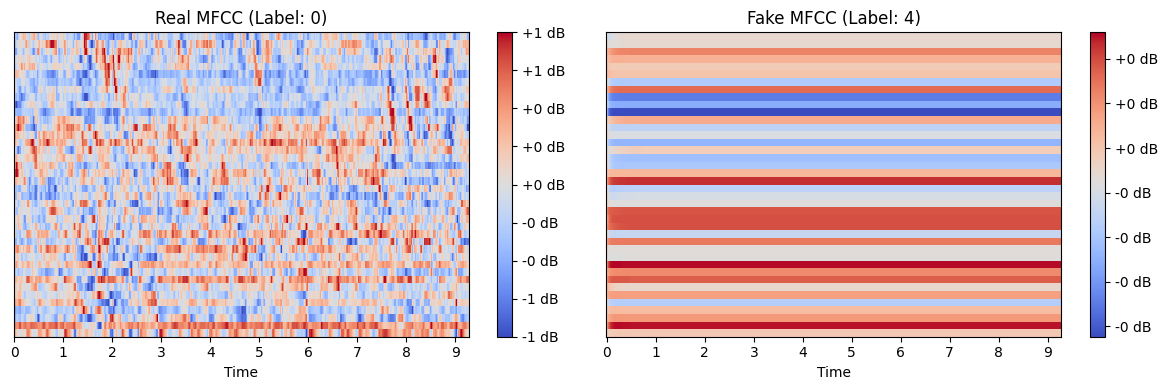

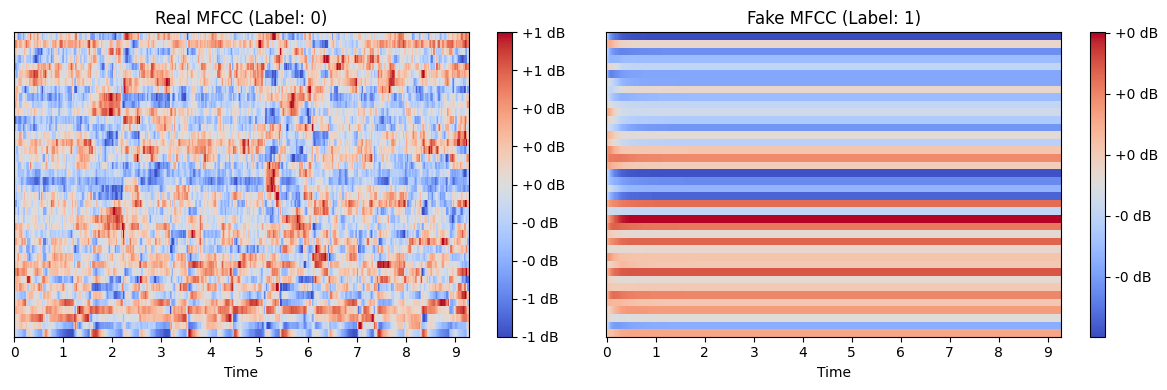

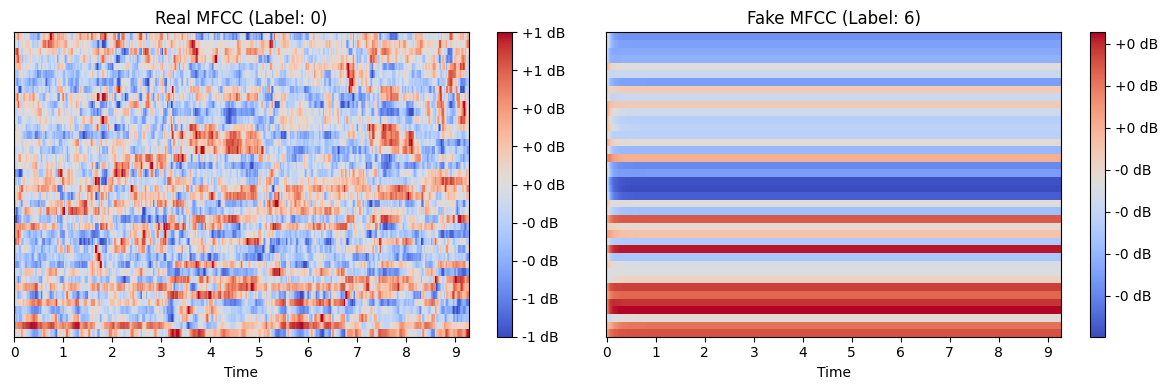

In [63]:
import matplotlib.pyplot as plt
import librosa.display

def plot_real_vs_fake(real_dataset, generator, noise_dim=100, num_samples=5):
    generator.eval()
    
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim, device=device)
        labels = torch.randint(0, 10, (num_samples,), device=device)  # ✅ provide labels
        fake_mfccs = generator(noise, labels).cpu()  # ✅ pass both noise and labels

    for i in range(num_samples):
        real_mfcc, real_label = real_dataset[i]
        fake_mfcc = fake_mfccs[i]

        # Convert [T, 40] → [40, T] for librosa display
        real_mfcc = real_mfcc.numpy().T
        fake_mfcc = fake_mfcc.numpy().T

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        img1 = librosa.display.specshow(real_mfcc, ax=axes[0], x_axis='time', sr=22050, hop_length=512)
        axes[0].set_title(f"Real MFCC (Label: {real_label})")

        img2 = librosa.display.specshow(fake_mfcc, ax=axes[1], x_axis='time', sr=22050, hop_length=512)
        axes[1].set_title(f"Fake MFCC (Label: {labels[i].item()})")

        fig.colorbar(img1, ax=axes[0], format="%+2.0f dB")
        fig.colorbar(img2, ax=axes[1], format="%+2.0f dB")

        plt.tight_layout()
        plt.show()

# Plot real vs fake MFCCs
plot_real_vs_fake(train_dataset, generator, noise_dim=100, num_samples=5)

In [ ]:
class Net6(nn.Module):
    def __init__(self, input_size=40, hidden_size=256, num_layers=2, num_classes=10, dropout=0.3):
        super(Net6, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,  # only applies if num_layers > 1
            batch_first=True,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # x: [batch, time, n_mfcc]
        out, _ = self.lstm(x)      # [B, T, H]
        out = self.dropout(out[:, -1, :])  # 🔥 Dropout after LSTM
        out = self.fc(out)
        return out

In [ ]:
# Load MFCC dataset
from torch.utils.data import random_split, DataLoader

# 1. Split the augmented dataset
total_len = len(augmented_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_set, val_set, test_set = random_split(
    augmented_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# 2. Create DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Initialize and train Net5
model = Net6().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=60, early_stopping=True, patience=10)

# Save
torch.save(model.state_dict(), 'Net6-mfcc-lstm.pth')

# Final evaluation
print(f"✅ Train Acc: {evaluate_accuracy(model, train_loader, device):.2%}")
print(f"✅ Val Acc: {evaluate_accuracy(model, val_loader, device):.2%}")
print(f"✅ Test Acc: {evaluate_accuracy(model, test_loader, device):.2%}")
